## Prerequisite: Mean Variance Portfolio

Many basic helper functions came from a simplified MVP in `mvp.py`

I want to give thanks to [this website](https://gist.github.com/yhilpisch/5bf53944ffd13696fb4102a77602378c) and [this youtube video](https://youtu.be/WRhrd0e4SSc?si=IfbF4KgZFmIG9Rbh).

You migth also find this [slide deck][1] useful at some point for more rigour!

[1]:https://palomar.home.ece.ust.hk/ELEC5470_lectures/slides_risk_parity_portfolio.pdf

In [1]:
from scipy.optimize import minimize
from mvp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading data

- The data is obtained from `yfinance.download` in `data.ipynb` as a CSV file.
- We calculate the return `ret` using $r_t = \log{r_t} - \log{r_{t-1}}$
- The number of assets is `n`

In [2]:
data = pd.read_csv("universe.csv", index_col=0, parse_dates=True).dropna()
data = data.loc['2022-1-1':] # select all data since 2022 for efficiency

rets = np.log(data/data.shift(1)) # we use log return
n = len(data.columns)

## Equal Weight and Equal Risk Portfolio

The goal here is to make the RC (relative contribution) of each stock the same. This is the definition of a risk parity portfolio. We first define a risk function (volatility, std dev, or root of variance) and for N assets:

$$
\sigma(w) = \sqrt{w^T Q w}
$$

Note that
$$
MRC_i = \frac{\partial \sigma(w)}{\partial w_i} = \frac{(Qw)_i}{\sqrt{w^TQw}}
$$

The goal is
$$
RC_i = \frac{\sigma(w)}N \text{ and } RRC_i = \frac{1}N
$$

This is parallel to a equally weighted portfolio where $w_i = 1/N$

The following code initializes equal weights and we will later optimize this to create portfolio with equal risk contributions.

([<matplotlib.patches.Wedge at 0x14a34f170>,
 [Text(0.7778174593052024, 0.7778174593052023, 'AAPL'),
  Text(-0.7778174593052023, 0.7778174593052024, 'BTC-USD'),
  Text(-0.7778174593052025, -0.7778174593052023, 'GC=F'),
  Text(0.7778174593052022, -0.7778174593052025, '^GSPC')],
 [Text(0.4242640687119285, 0.42426406871192845, '25.0%'),
  Text(-0.42426406871192845, 0.4242640687119285, '25.0%'),
  Text(-0.4242640687119286, -0.42426406871192845, '25.0%'),
  Text(0.4242640687119284, -0.4242640687119286, '25.0%')])

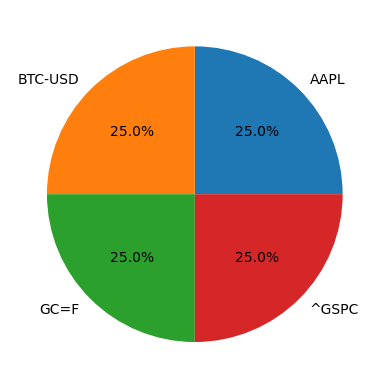

In [4]:
w =  np.array(n * [1/n]) # array of n elements, each is 1/n

# This is the goal of a equally weighted portfolio
plt.pie(w, labels=data.columns, autopct='%1.1f%%')

In [5]:
cov = rets.cov() * 252
vol = portfolio_volatility(w, rets)

## Risk Parity Theory

We define marginal risk contribution, risk contribution, and relative risk contribution as follows:

$$
MRC_i = \frac{\partial \sigma(w)}{\partial w_i} \\

RC_i = w_i \frac{\partial \sigma(w)}{\partial w_i} \\

RRC_i = \frac{RC_i}{\sigma(w)} = \frac{w_i(Qw)_i}{\sqrt{w^TQw}}\\
$$

Observe that from Euler's theorem

$$
\sum^N_{i=1}RC_i = \sigma(w)
$$


The following script does everything in the same way as above.

Text(0.5, 1.0, 'Equally Weighted Portfolio')

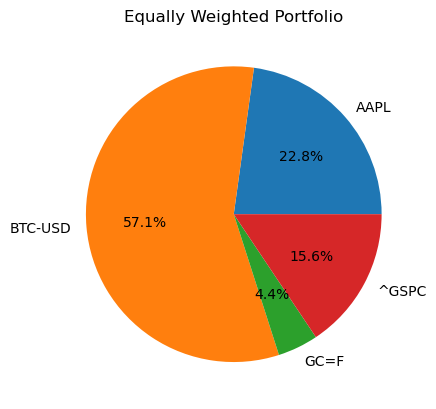

In [7]:
def rel_risk_contributions(weights, rets=rets):
    vol = portfolio_volatility(weights, rets)
    cov = rets.cov()
    mrc = np.dot(cov, weights) / vol # marginal volatility or marginal risk contributions
    rc = mrc * weights # risk contributinos
    rrc = rc / rc.sum() # note rc.sum() = vol(w)
    return rrc

rrc = rel_risk_contributions(w)
plt.pie(rrc, labels=data.columns, autopct='%1.1f%%')
plt.title('Relative Risk Contributions of EWP')

## Risk Budget Portfolio (RBP)

RPP is a special case of RBP where $RC_i = 1/N$, but in general we can allocate portfolio according to predetermiend risk profile weights $b$, with $1^Tb = 1$ and $b \geq 0$.

$$
RC_i = b_i \sigma(w) \\
RCC_i = b_i
$$

In the optimize script below just adjust `target` if you want to use RBP.

Text(0.5, 1.0, 'Optimal Portfolio Weights')

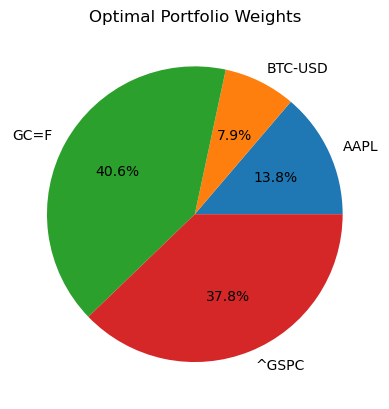

In [8]:
# mean squared error -- minimise the difference between risk contributions
def mse_risk_contributions(weights, target, rets=rets):
    rc = rel_risk_contributions(weights, rets)
    mse = ((rc - target) ** 2).mean()
    return mse * 100

bnds = n * [(0, 1),]

cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}

target = n * [1 / n,]  # risk parity as target

target = [0.2, 0.2, 0.2, 0.4]  # risk budget as target

opt = minimize(lambda w: mse_risk_contributions(w, target=target),
               w, bounds=bnds, constraints=cons)

w_ = opt["x"]

plt.pie(w_, labels=data.columns, autopct='%1.1f%%')
plt.title('Optimal Portfolio Weights')

In [9]:
rrc = rel_risk_contributions(w_)
volatility = portfolio_volatility(w_, rets)
print(rrc)
print(volatility)

[0.20001316 0.20001189 0.20005895 0.399916  ]
0.143715786287781
